# Test positional embedding

To be sure that our model can take a positional embedding and learn a meaningful signal from it, create a test where:
* First half of the sequence has Gaussian noise $\geq 0$
* Second half of the sequence hsa Gaussian noise $\leq 0$
Use variable sequence lengths such that the model cannot just memorize certain outputs to be positive/negative.

This corresponds to the json training config file:

```json
{
    "results_dir": "/home/t-kevinwu/projects/protein_diffusion/models_overfitted/results",
    "shift_angles_zero_twopi": false,
    "noise_prior": "gaussian",
    "timesteps": 250,
    "variance_schedule": "cosine",
    "variance_scale": 1.0,
    "time_encoding": "gaussian_fourier",
    "num_hidden_layers": 12,
    "hidden_size": 384,
    "intermediate_size": 768,
    "num_heads": 12,
    "position_embedding_type": "absolute",
    "dropout_p": 0.1,
    "gradient_clip": 1.0,
    "lr": 5e-05,
    "loss": "huber",
    "l2_norm": 0.0,
    "l1_norm": 0.0,
    "circle_reg": 0.1,
    "min_epochs": 1000,
    "max_epochs": 2000,
    "early_stop_patience": 0,
    "use_swa": false,
    "subset": 500,
    "exhaustive_validation_t": false,
    "syn_noiser": "halfhalf",
    "single_dist_debug": false,
    "single_angle_debug": false,
    "single_timestep_debug": false,
    "batch_size": 128,
    "multithread": true
}
```

In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
epoch = 1999
with open(f"/home/t-kevinwu/projects/protein_diffusion/models_overfitted/results/valid_preds/{epoch}_preds.json") as source:
    valid_preds = json.load(source)
    for k, v in valid_preds.items():
        valid_preds[k] = np.array(v)
valid_preds.keys()

dict_keys(['known_noise', 'predicted_noise', 'attn_mask', 'losses'])

In [3]:
valid_preds['attn_mask'].shape

(26, 512)

In [4]:
valid_preds['known_noise'].shape

(26, 512, 1)

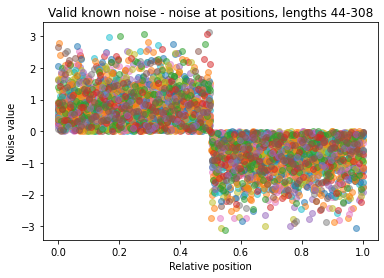

In [5]:
# Validate the true noise behaves as designed
def plot_by_position(preds, attn_mask, title_prefix:str=""):
    fig, ax = plt.subplots()
    lengths = []
    for mat, mask in zip(preds, attn_mask):
        mat = mat.squeeze()
        vals = mat[np.where(mask)]
        pos = np.linspace(0, 1, num=len(vals))
        ax.scatter(pos, vals, alpha=0.5)
        lengths.append(len(vals))

    title = "noise at positions, lengths {}-{}".format(min(lengths), max(lengths))
    if title_prefix:
        title = ' - '.join([title_prefix.strip(), title])
    ax.set(
        xlabel="Relative position",
        ylabel="Noise value",
        title=title
    )
    return fig

plot_by_position(valid_preds['known_noise'], valid_preds['attn_mask'], title_prefix="Valid known noise").show()

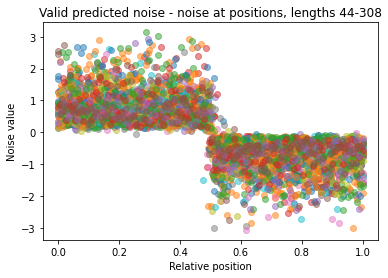

In [6]:
# Plot predicted noise
plot_by_position(valid_preds['predicted_noise'], valid_preds['attn_mask'], title_prefix="Valid predicted noise").show()

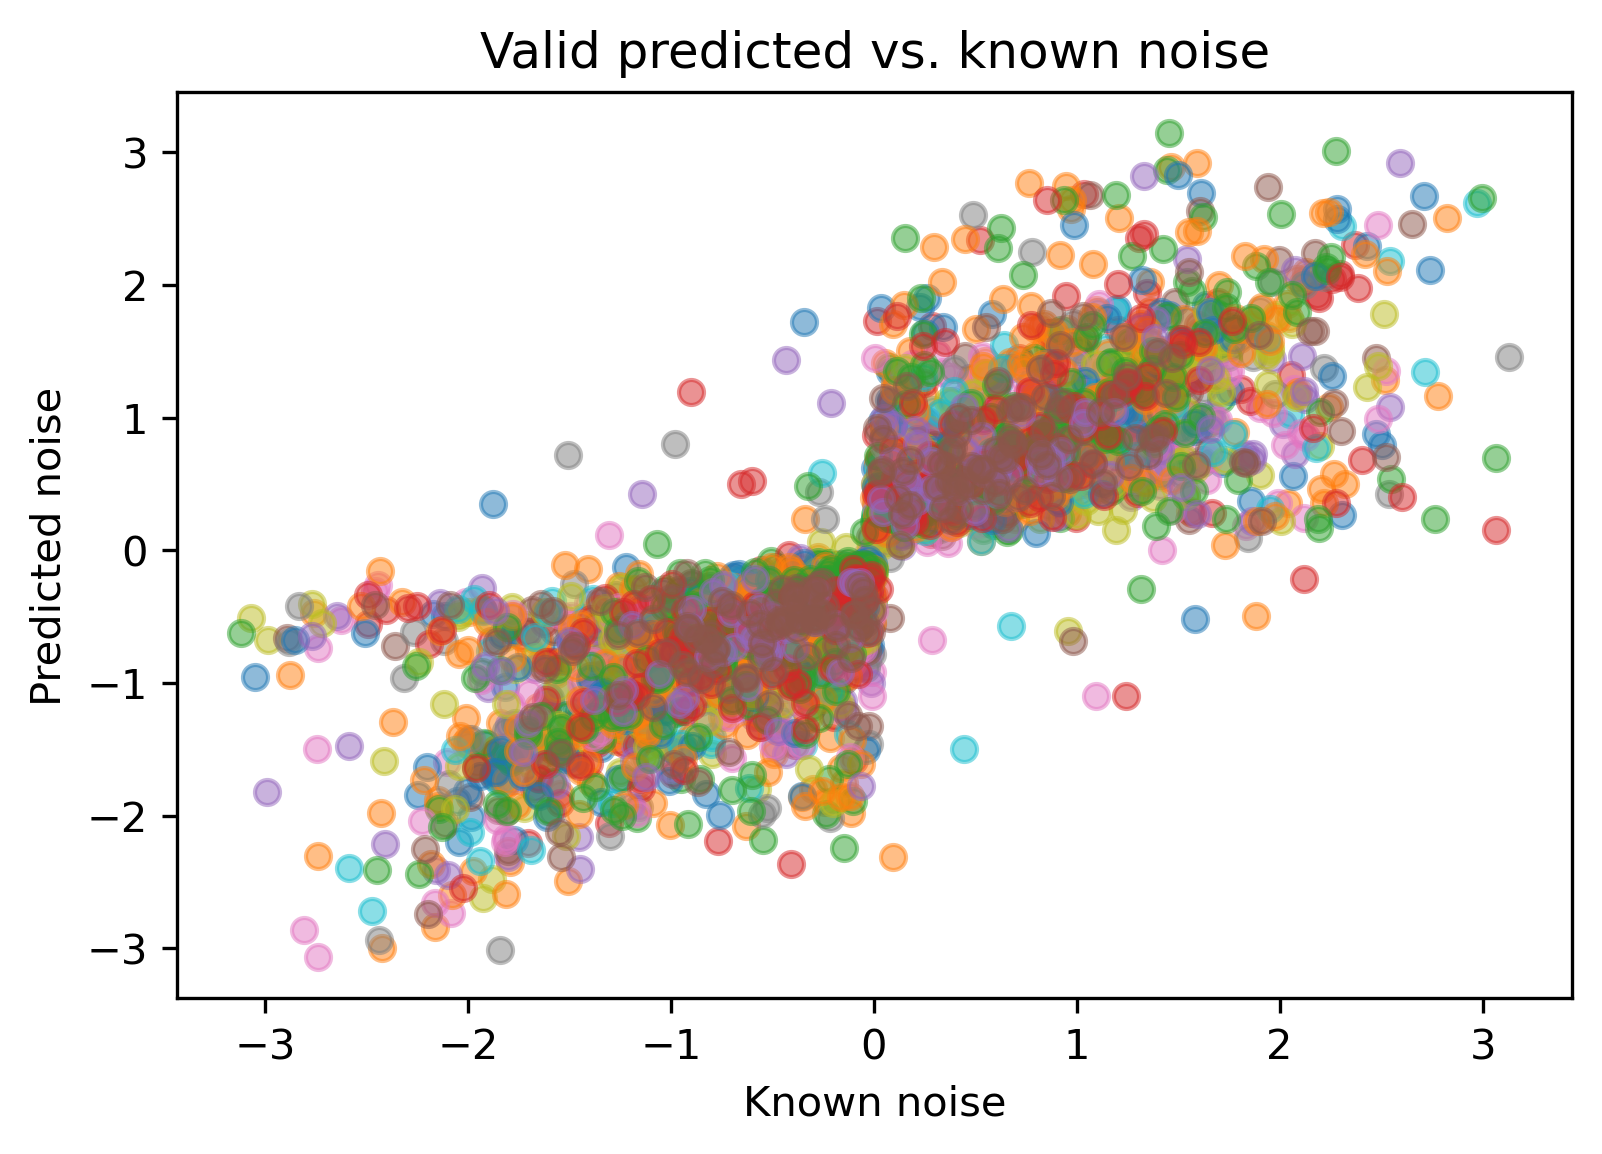

In [7]:
def plot_scatter(preds, title:str):
    fig, ax = plt.subplots(dpi=300)
    for truth, preds, mask in zip(valid_preds['known_noise'], valid_preds['predicted_noise'], valid_preds['attn_mask']):
        truth = truth.squeeze()[np.where(mask)]
        preds = preds.squeeze()[np.where(mask)]
        ax.scatter(truth, preds, alpha=0.5)
    
    ax.set(
        xlabel="Known noise",
        ylabel="Predicted noise",
        title=title,
    )
    return fig

plot_scatter(valid_preds, title="Valid predicted vs. known noise").show()